In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from loader import train_loader, val_loader, test_loader, scaler
from models.hfm import HybridForecastingModel

In [2]:
print(torch.cuda.is_available())      # True nếu có GPU
print(torch.cuda.device_count())      # Số lượng GPU có thể sử dụng
print(torch.cuda.get_device_name(0))  # Tên của GPU

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
model = HybridForecastingModel(
	window_size=30,
	num_series=2,
	static_dim=18,
	d_model=64,
	nhead=4,
	num_layers_transformer=2,
    n_blocks_nhits=3,
	nhits_hidden_dim=128, 
	nhits_n_layers=3, 
	deepar_num_layers=2,
    dropout=0.1, 
	output_dim=2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [4]:
# Cấu hình optimizer, loss, scheduler
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

num_epochs = 100  # Bạn có thể tăng số epoch nếu cần
best_val_loss = float('inf')
train_losses = []
val_losses = []

In [5]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_seq, x_cal)
        loss = criterion(outputs, y)
        loss.backward()
        
        # Áp dụng gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            outputs = model(x_seq, x_cal)
            loss = criterion(outputs, y)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'checkpoints/HFM.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 0.1806
Best model updated at epoch 2 with validation loss 0.1422
Best model updated at epoch 3 with validation loss 0.1341
Best model updated at epoch 4 with validation loss 0.1222
Best model updated at epoch 5 with validation loss 0.1155
Best model updated at epoch 6 with validation loss 0.0955
Best model updated at epoch 7 with validation loss 0.0935
Best model updated at epoch 8 with validation loss 0.0813
Best model updated at epoch 9 with validation loss 0.0772
Epoch [10/100], Train Loss: 0.0650, Val Loss: 0.0696
Best model updated at epoch 10 with validation loss 0.0696
Best model updated at epoch 11 with validation loss 0.0662
Best model updated at epoch 13 with validation loss 0.0610
Best model updated at epoch 14 with validation loss 0.0565
Best model updated at epoch 15 with validation loss 0.0536
Best model updated at epoch 19 with validation loss 0.0479
Epoch [20/100], Train Loss: 0.0345, Val Loss: 0.0547
Best model updated

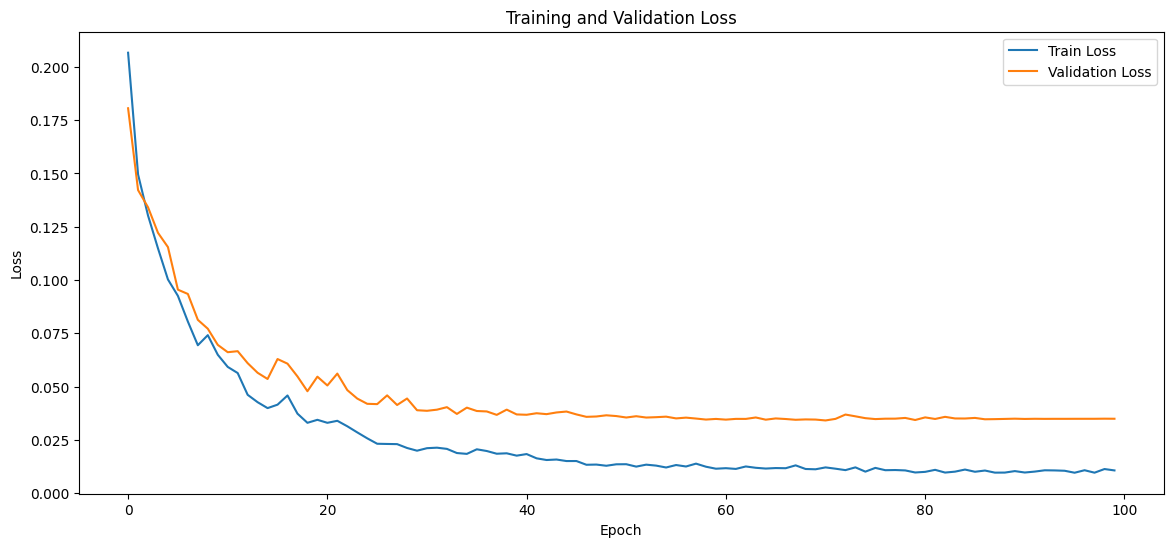

In [6]:
# Vẽ đồ thị loss
plt.figure(figsize=(14, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [7]:
# Load lại mô hình tốt nhất
checkpoint = torch.load('checkpoints/HFM.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded with validation loss: {checkpoint['val_loss']:.4f}")

Best model loaded with validation loss: 0.0342


In [8]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            outputs = model(x_seq, x_cal)
            preds.append(outputs.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

In [9]:
# Dự báo trên tập train và test
train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

# Tính các chỉ số đánh giá trên tập test
r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.9387
Test MAPE: 0.5183
Test RMSE: 171857.2969


In [10]:
# Tính các chỉ số riêng cho Units và Revenue
r2_units = r2_score(test_actuals_inv[:, 0], test_preds_inv[:, 0])
mape_units = mean_absolute_percentage_error(test_actuals_inv[:, 0], test_preds_inv[:, 0])
rmse_units = np.sqrt(mean_squared_error(test_actuals_inv[:, 0], test_preds_inv[:, 0]))

print(f"Test Units R-squared: {r2_units:.4f}")
print(f"Test Units MAPE: {mape_units:.4f}")
print(f"Test Units RMSE: {rmse_units:.4f}")

r2_revenue = r2_score(test_actuals_inv[:, 1], test_preds_inv[:, 1])
mape_revenue = mean_absolute_percentage_error(test_actuals_inv[:, 1], test_preds_inv[:, 1])
rmse_revenue = np.sqrt(mean_squared_error(test_actuals_inv[:, 1], test_preds_inv[:, 1]))

print(f"Test Revenue R-squared: {r2_revenue:.4f}")
print(f"Test Revenue MAPE: {mape_revenue:.4f}")
print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

Test Units R-squared: 0.9343
Test Units MAPE: 0.6141
Test Units RMSE: 33.1439
Test Revenue R-squared: 0.9431
Test Revenue MAPE: 0.4225
Test Revenue RMSE: 243042.9531


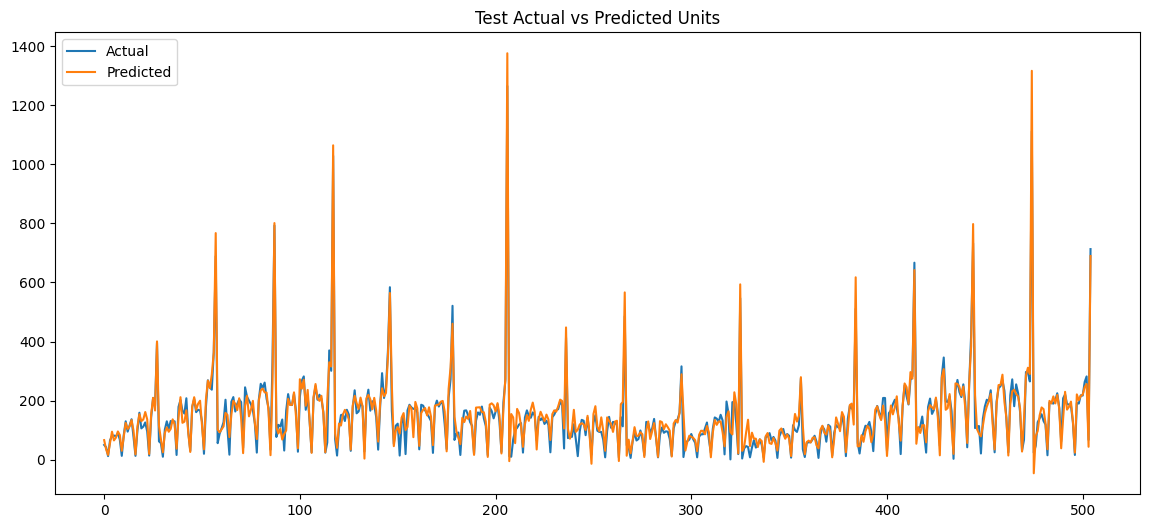

In [11]:
# Vẽ đồ thị dự báo và thực tế đối với Units
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 0], label='Actual')
plt.plot(test_preds_inv[:, 0], label='Predicted')
plt.title('Test Actual vs Predicted Units')
plt.legend()
plt.show()

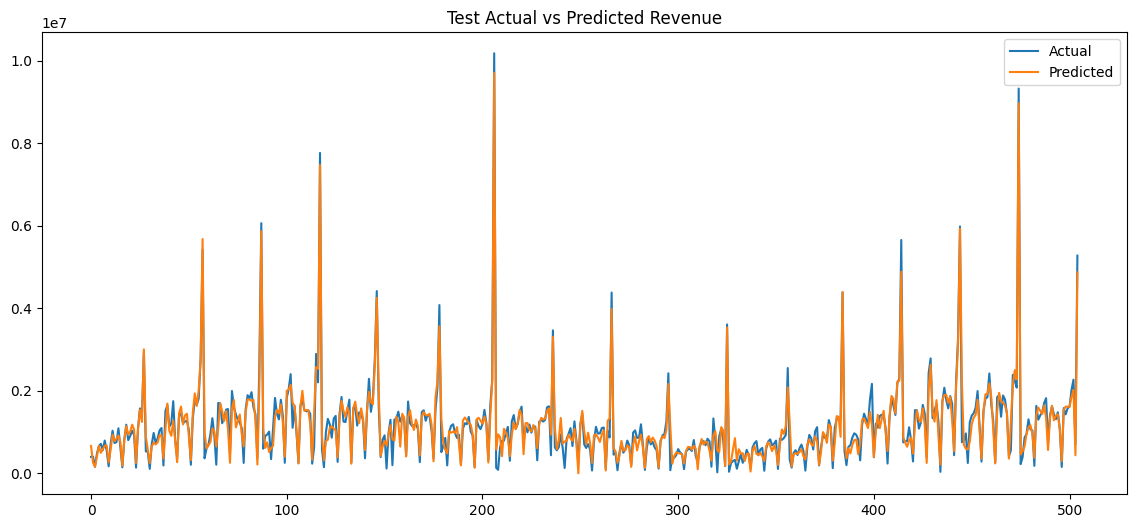

In [12]:
# Vẽ đồ thị dự báo và thực tế đối với Revenue
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 1], label='Actual')
plt.plot(test_preds_inv[:, 1], label='Predicted')
plt.title('Test Actual vs Predicted Revenue')
plt.legend()
plt.show()